Score de Silhouette KMeans: 0.5900070736677112
Score de Silhouette GMM: 0.33595753362947045
Caractéristiques moyennes des clusters (KMeans):
         Total_MONT_LOC  Mean_MONT_LOC  Domiciliation_Count  Active_Years  \
Cluster                                                                     
0          1.947458e+10   2.051264e+08           122.093596      5.305419   
1          2.750463e+09   1.862997e+08             9.626062      1.677054   
2          8.366011e+11   4.413832e+09           967.250000      5.250000   
3          4.411916e+11   1.199616e+08          4297.000000      6.000000   

         KMeans_Cluster  GMM_Cluster  
Cluster                               
0                   0.0     1.433498  
1                   1.0     0.767705  
2                   2.0     2.000000  
3                   3.0     3.000000  
                                    Total_MONT_LOC  Mean_MONT_LOC  \
NOM client                                                          
3MD ENERGY SA           

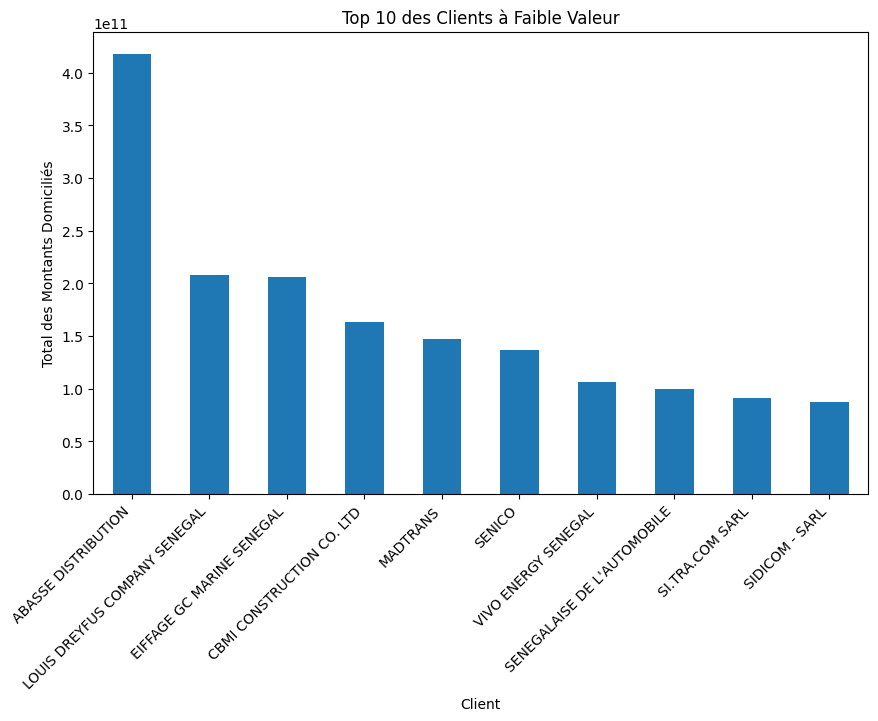


Top 10 des Clients à Haute Fréquence :
NOM client
ICS                                    1.837787e+11
PETOWAL MINING COMPANY SA              1.193649e+11
AGRO BUSINESS TRADING                  7.537385e+10
COMPAGNIE SUCRIERE SENEGALAISE         4.134524e+10
DIEYE GLOBAL FOOD AND IMPORT EXPORT    3.344229e+10
AKTIVCO SENEGAL                        3.011484e+10
CHINA GEZHOUBA GROUP INTERNATIONAL     2.443430e+10
PFO AFRICA SENEGAL                     2.220439e+10
DIEYE TRADING INTERNATIONAL            2.058266e+10
COMPTOIR COMMERCIAL MARIAMA SARL       1.978864e+10
Name: MONT_LOC, dtype: float64


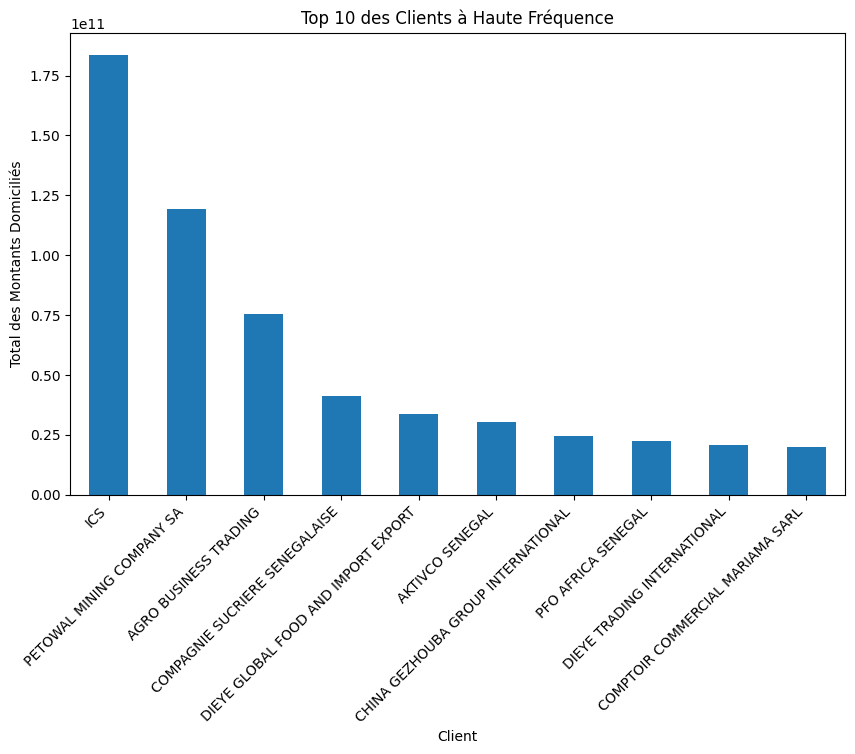


Top 10 des Clients Premium :
NOM client
SABODALA GOLD OPERATIONS              1.559278e+12
TOTALENERGIES MARKETING SENEGAL SA    1.273668e+12
COMPT COM MAND                        4.482007e+11
DAKAR MOBILITE                        6.525780e+10
Name: MONT_LOC, dtype: float64


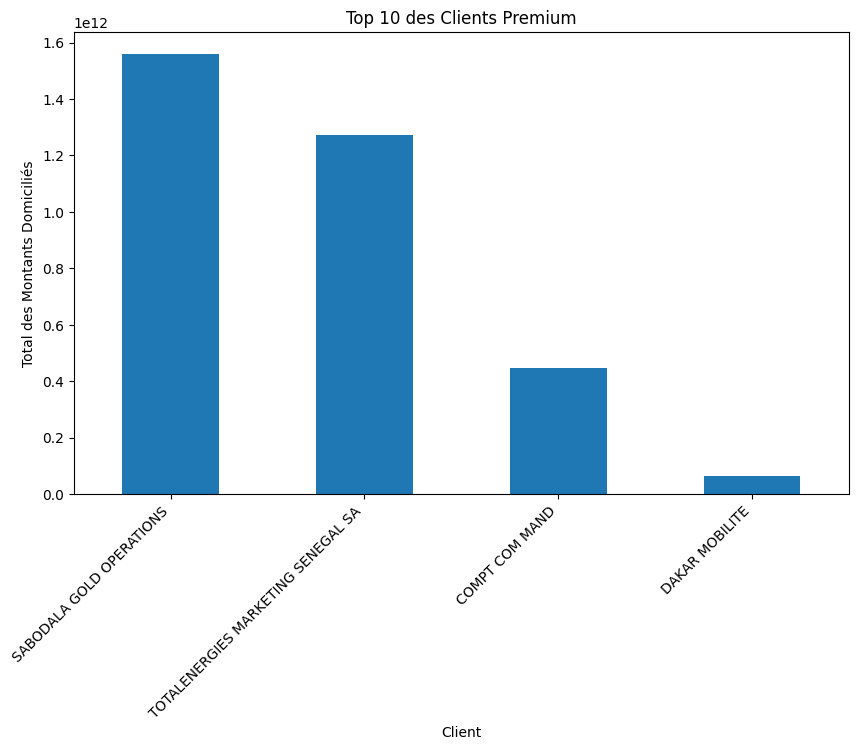


Top 10 des Clients à Moyenne Valeur :
NOM client
GRANDE COTE OPERATION                   8.375744e+11
SENECOR                                 3.141903e+11
COMPAGNIE SENEGALAISE DE LUBRIFIANTS    1.718101e+11
Name: MONT_LOC, dtype: float64


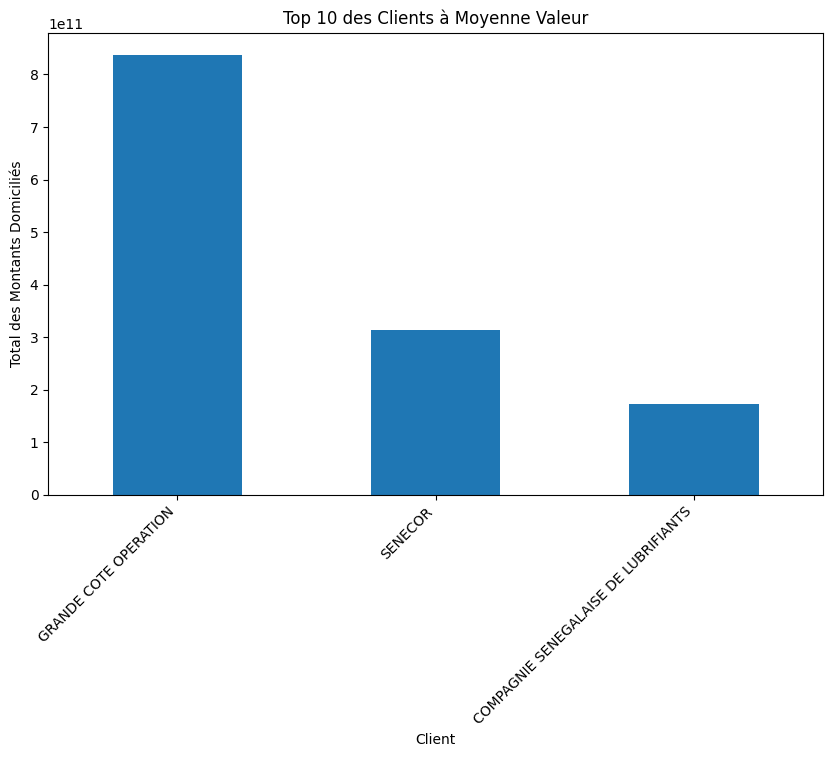

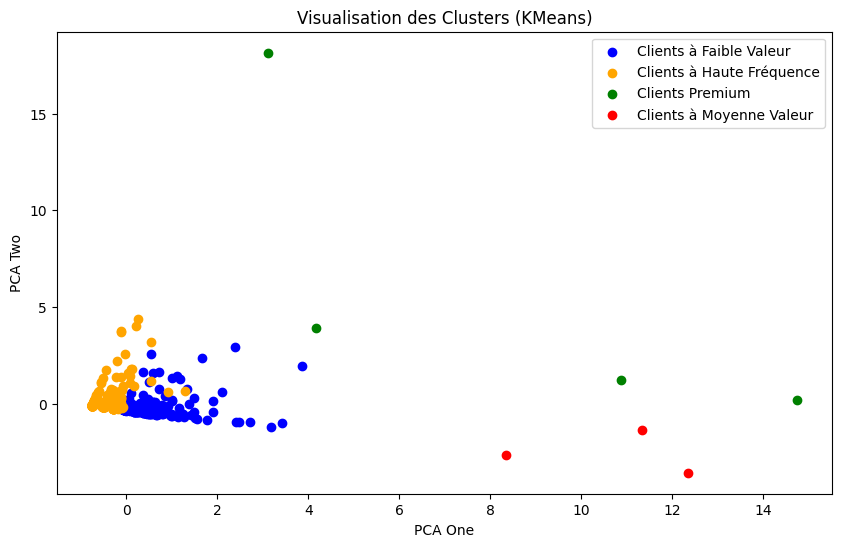

Le modèle utilisé est : KMeans avec un score de silhouette de : 0.5900070736677112


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Charger les données
file_path = 'Domiciliation new_ 2019_2024.csv'
domiciliation = pd.read_csv(file_path, delimiter=';')

# Nettoyage des noms de colonnes pour enlever les espaces
domiciliation.columns = domiciliation.columns.str.strip()

# Conversion des types de données
domiciliation['DOUV'] = pd.to_datetime(domiciliation['DOUV'], format='%d/%m/%Y')
domiciliation['MONT_LOC'] = pd.to_numeric(domiciliation['MONT_LOC'], errors='coerce')
domiciliation['YEAR'] = domiciliation['DOUV'].dt.year

# Calculer des statistiques supplémentaires pour chaque client
client_stats = domiciliation.groupby('NOM client').agg({
    'MONT_LOC': ['sum', 'mean', 'count'],
    'YEAR': 'nunique'
}).fillna(0)

client_stats.columns = ['Total_MONT_LOC', 'Mean_MONT_LOC', 'Domiciliation_Count', 'Active_Years']

# Normaliser les données
scaler = StandardScaler()
client_stats_normalized = scaler.fit_transform(client_stats)

# Appliquer KMeans et comparer avec GMM
n_clusters = 4

# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
client_stats['KMeans_Cluster'] = kmeans.fit_predict(client_stats_normalized)
silhouette_avg_kmeans = silhouette_score(client_stats_normalized, client_stats['KMeans_Cluster'])

# GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(client_stats_normalized)
client_stats['GMM_Cluster'] = gmm.predict(client_stats_normalized)
silhouette_avg_gmm = silhouette_score(client_stats_normalized, client_stats['GMM_Cluster'])

print(f"Score de Silhouette KMeans: {silhouette_avg_kmeans}")
print(f"Score de Silhouette GMM: {silhouette_avg_gmm}")

# Choisir le modèle avec le meilleur score de silhouette
best_model = 'KMeans' if silhouette_avg_kmeans > silhouette_avg_gmm else 'GMM'
best_score = silhouette_avg_kmeans if best_model == 'KMeans' else silhouette_avg_gmm

# Renommer les clusters en fonction des caractéristiques observées pour le meilleur modèle
cluster_column = 'KMeans_Cluster' if best_model == 'KMeans' else 'GMM_Cluster'
client_stats['Cluster'] = client_stats[cluster_column]
clusters = client_stats.groupby('Cluster').mean()

print(f"Caractéristiques moyennes des clusters ({best_model}):")
print(clusters)

# Renommer les clusters
cluster_names = {
    0: 'Clients à Faible Valeur',
    1: 'Clients à Haute Fréquence',
    2: 'Clients Premium',
    3: 'Clients à Moyenne Valeur'
}
client_stats['Cluster Name'] = client_stats['Cluster'].map(cluster_names)

# Vérifier les colonnes du DataFrame après la création des clusters
print(client_stats.head())

# Merge les résultats de clustering avec les données originales
domiciliation = domiciliation.merge(client_stats[[cluster_column, 'Cluster Name']], left_on='NOM client', right_index=True, how='left')

# Vérifier que la fusion s'est bien déroulée et que les colonnes sont présentes
print(domiciliation.columns)

# Afficher le top 10 des clients par cluster en global
for cluster_id, cluster_name in cluster_names.items():
    print(f"\nTop 10 des {cluster_name} :")
    filtered_data = domiciliation[domiciliation['Cluster Name'] == cluster_name]
    if (filtered_data.empty):
        print(f"Aucun client trouvé pour {cluster_name}")
        continue
    top_10_clients = filtered_data.groupby('NOM client')['MONT_LOC'].sum().sort_values(ascending=False).head(10)
    print(top_10_clients)
    
    plt.figure(figsize=(10, 6))
    top_10_clients.plot(kind='bar', title=f'Top 10 des {cluster_name}')
    plt.xlabel('Client')
    plt.ylabel('Total des Montants Domiciliés')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Réduction de dimensionnalité avec PCA pour visualiser les clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(client_stats_normalized)

client_stats['pca-one'] = pca_result[:,0]
client_stats['pca-two'] = pca_result[:,1]

# Visualiser les clusters sur un graphique de dispersion
plt.figure(figsize=(10, 6))

# Couleurs pour chaque cluster
colors = ['blue', 'orange', 'green', 'red']

for cluster_id, cluster_name in cluster_names.items():
    cluster_data = client_stats[client_stats['Cluster Name'] == cluster_name]
    plt.scatter(cluster_data['pca-one'], cluster_data['pca-two'], 
                label=cluster_name, color=colors[cluster_id])

plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.title(f'Visualisation des Clusters ({best_model})')
plt.legend()
plt.show()

# Afficher le modèle utilisé et son score
print(f"Le modèle utilisé est : {best_model} avec un score de silhouette de : {best_score}")
